In [57]:
from ahrs import Sensors
import pandas as pd
import numpy as np

In [58]:
# CONSTANTS
FS = 104.0  # Sampling frequency in Hz
FS_SEC = 1.0 / FS  # Sampling period in seconds
FS_MSEC = FS_SEC * 1000.0  # Sampling period in milliseconds

DEG_TO_RAD = np.pi / 180.0  # Degrees to radians conversion factor
RAD_TO_DEG = 180.0 / np.pi  # Radians to degrees conversion factor
G_TO_MS2 = 9.80665  # Gravity to m/s^2 conversion factor
MG_TO_MS2 = G_TO_MS2 / 1000.0  # Milli-gravity to m/s^2 conversion factor


In [59]:
sensors = pd.read_csv('data/imu1.csv')
sensors.head()

SAMPLE_LEN = len(sensors)
print(f"Sample length: {SAMPLE_LEN}")

Sample length: 18


In [60]:
import matplotlib.pyplot as plt

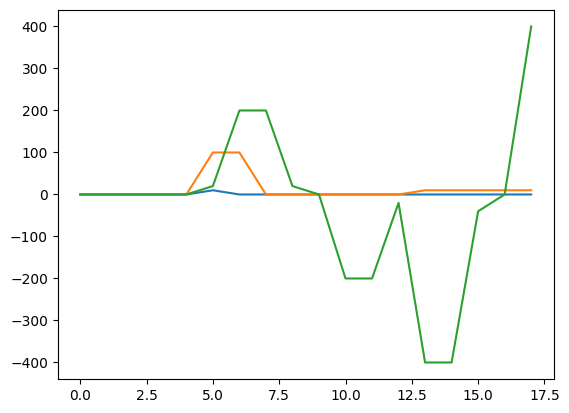

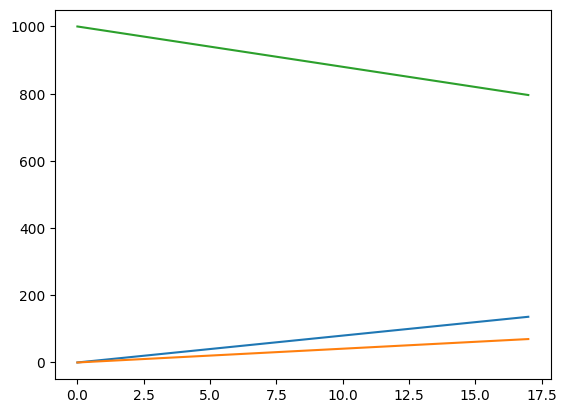

In [61]:
gyro_mdps = sensors[['gyro_x_mdps', 'gyro_y_mdps', 'gyro_z_mdps']] # m deg/s
# Convert to rad/s
gyro = gyro_mdps.to_numpy() * (DEG_TO_RAD * 1000.0)
accel_mg = sensors[['accel_x_mg', 'accel_y_mg', 'accel_z_mg']] # mg
# convert to m/s^2
accel = accel_mg.to_numpy() * MG_TO_MS2

plt.plot(gyro_mdps)
plt.show()
plt.plot(accel_mg)
plt.show()

# Tools

In [62]:
def detect_changes(euler, az_thresh=5.0, alt_thresh=5.0,
                   T_detection=2.0, T_validation=600.0, fs=104.0):
    """
    Detect abrupt orientation changes above thresholds and validate persistence.
    """ 
    az_thresh_rad = np.deg2rad(az_thresh)
    alt_thresh_rad = np.deg2rad(alt_thresh)

    events = []
    baseline = euler[0]
    state = "idle"
    start_idx = None

    for i, angles in enumerate(euler):
        d_az = np.abs(angles[0] - baseline[0])
        d_alt = np.abs(angles[1] - baseline[1])

        if state == "idle":
            if (d_az > az_thresh_rad) or (d_alt > alt_thresh_rad):
                start_idx = i
                state = "detection"

        elif state == "detection":
            if (i - start_idx) >= T_detection * fs:
                # Confirm detection
                events.append({"start_idx": start_idx,
                               "end_idx": i,
                               "angle_change": (d_az, d_alt),
                               "confirmed": False})
                state = "validation"
                validation_start = i

        elif state == "validation":
            if (i - validation_start) >= T_validation * fs:
                events[-1]["confirmed"] = True
                baseline = angles  # new stable baseline
                state = "idle"

    return events

# Preprocessing filters

In [63]:
%pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [69]:
from scipy.signal import butter, filtfilt
def preprocess_imu(accel, gyro, fs=104.0, cutoff=5.0, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff / nyq, btype='low')
    accel_filt = filtfilt(b, a, accel, axis=0)
    gyro_filt = filtfilt(b, a, gyro, axis=0)
    return accel_filt, gyro_filt

# Attitude filters

In [67]:
def estimate_orientation(accel, gyro, method="complementary", fs=104.0):
    from ahrs.common.orientation import q2euler
    from ahrs.common import Quaternion
    from ahrs.filters import Complementary, Madgwick, Mahony, UKF

    N = len(accel)
    euler = np.zeros((N, 3))

    if method == "complementary":
        filt = Complementary(acc=accel, gyr=gyro, frequency=fs, gain=0.1)
        for idx, q in enumerate(filt.Q):
            euler[idx] = q2euler(q)

    elif method == "ukf":
        filt = UKF()
        Q = np.tile([1., 0., 0., 0.], (N, 1))
        for t in range(1, N):
            Q[t] = filt.update(Q[t-1], gyr=gyro[t], acc=accel[t])
            euler[t] = q2euler(Q[t])
    else:
        if method == "madgwick":
            filt = Madgwick()
        elif method == "mahony":
            filt = Mahony()
        else:
            raise ValueError(f"Unknown method {method}")

        Q = np.tile([1., 0., 0., 0.], (N, 1))
        for t in range(1, N):
            Q[t] = filt.updateIMU(Q[t-1], gyr=gyro[t], acc=accel[t])
            euler[t] = q2euler(Q[t])

    return euler

In [70]:
def plot_orientation_comparison(results, labels=None, ground_truth=None, fs=104.0):
    import matplotlib.pyplot as plt
    import numpy as np

    if labels is None:
        labels = [f"Method {i}" for i in range(len(results))]

    t = np.arange(results[0].shape[0]) / fs
    titles = ["Yaw (azimuth)", "Pitch (altitude)", "Roll"]

    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    for j in range(3):
        for res, lbl in zip(results, labels):
            axs[j].plot(t, np.rad2deg(res[:, j]), label=lbl, alpha=0.8)
        if ground_truth is not None:
            axs[j].plot(t, np.rad2deg(ground_truth[:, j]),
                        label="Ground Truth", linestyle="--", color="k")
        axs[j].set_ylabel(f"{titles[j]} [deg]")
        axs[j].legend(loc="best")
        axs[j].grid(True)

    axs[-1].set_xlabel("Time [s]")
    plt.suptitle("Orientation Comparison Across Filters")
    plt.show()


UNFILTERED DATA
Processing with complementary filter...
Detected 0 events with complementary filter.
Processing with madgwick filter...
Detected 0 events with madgwick filter.
Processing with mahony filter...
Detected 0 events with mahony filter.
Processing with ukf filter...
Detected 0 events with ukf filter.


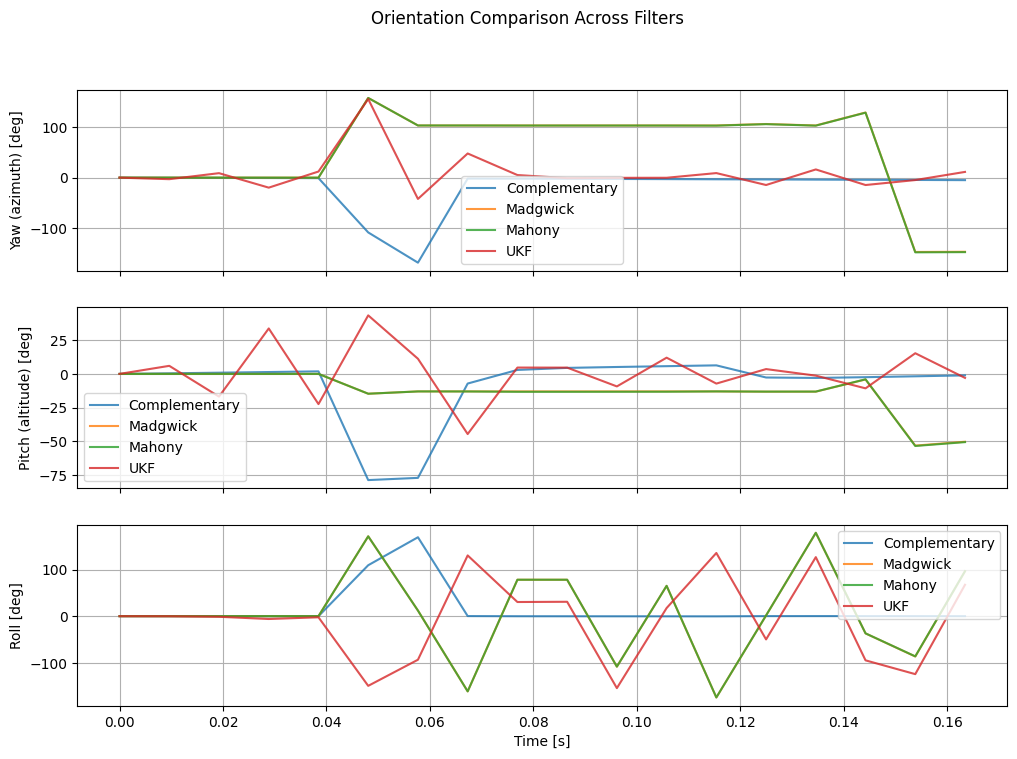

FILTERED DATA
Processing with complementary filter...
Detected 0 events with complementary filter.
Processing with madgwick filter...
Detected 0 events with madgwick filter.
Processing with mahony filter...
Detected 0 events with mahony filter.
Processing with ukf filter...
Detected 0 events with ukf filter.


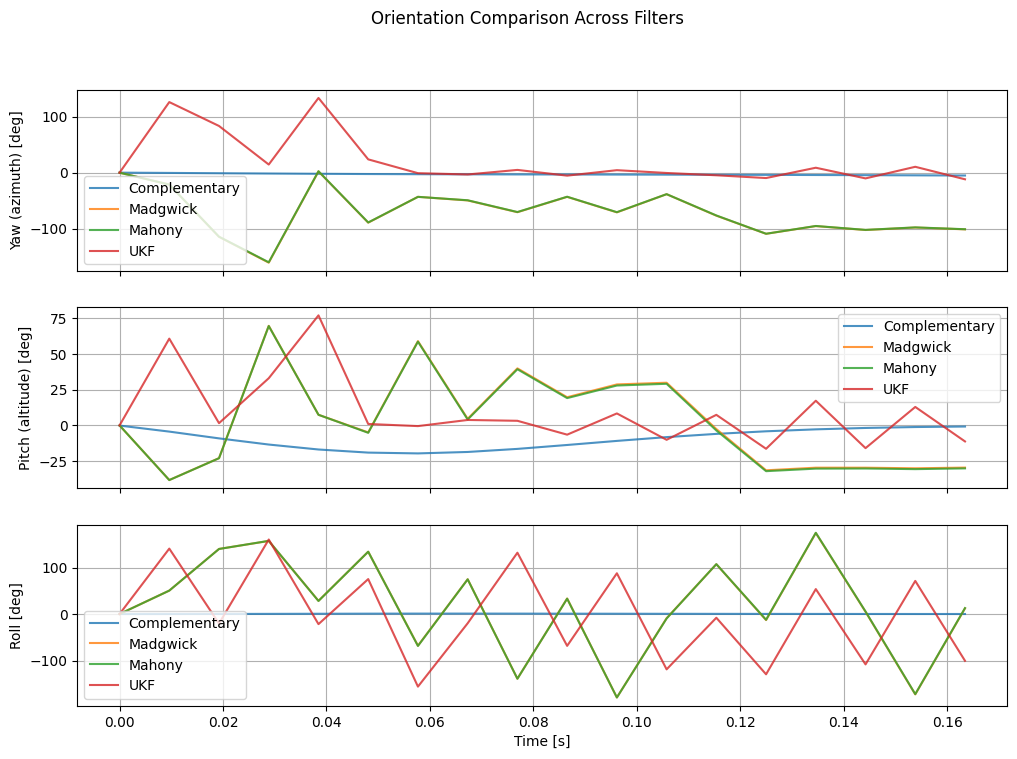

In [ ]:
filters = ["complementary", "madgwick", "mahony", "ukf"]
results = {}

# Unfiltered
print("UNFILTERED DATA")
for method in filters:
    print(f"Processing with {method} filter...")
    euler = estimate_orientation(accel, gyro, method=method, fs=FS)
    events = detect_changes(euler, az_thresh=5.0, alt_thresh=5.0,
                            T_detection=2.0, T_validation=600.0, fs=FS)
    results[method] = {
        "euler": euler,
        "events": events
    }
    print(f"Detected {len(events)} events with {method} filter.")

euler_list = [results[method]["euler"] for method in filters]
plot_orientation_comparison(
    euler_list,
    labels=["Complementary", "Madgwick", "Mahony", "UKF"]
)
# Filtered
print("FILTERED DATA")
for method in filters:
    print(f"Processing with {method} filter...")
    accel_filt, gyro_filt = preprocess_imu(accel, gyro, fs=FS)
    euler = estimate_orientation(accel_filt, gyro_filt, method=method, fs=FS)
    events = detect_changes(euler, az_thresh=5.0, alt_thresh=5.0,
                            T_detection=2.0, T_validation=600.0, fs=FS)
    results[method] = {
        "euler": euler,
        "events": events
    }
    print(f"Detected {len(events)} events with {method} filter.")

euler_list = [results[method]["euler"] for method in filters]
plot_orientation_comparison(
    euler_list,
    labels=["Complementary", "Madgwick", "Mahony", "UKF"]
)


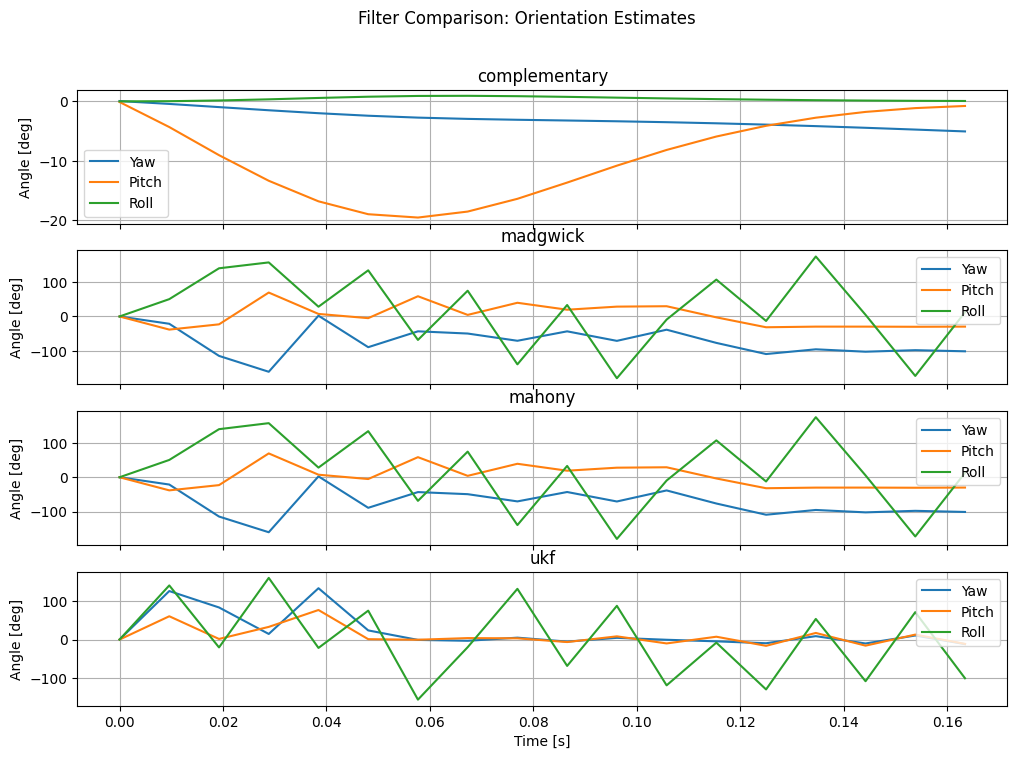

In [105]:
def plot_side_by_side(results, labels, fs=104.0):
    """
    Compare filters in separate subplots for easier visual inspection.
    """
    t = np.arange(results[0].shape[0]) / fs
    fig, axs = plt.subplots(len(results), 1, figsize=(12, 2*len(results)), sharex=True)

    for ax, res, lbl in zip(axs, results, labels):
        ax.plot(t, np.rad2deg(res[:,0]), label="Yaw")
        ax.plot(t, np.rad2deg(res[:,1]), label="Pitch")
        ax.plot(t, np.rad2deg(res[:,2]), label="Roll")
        ax.set_ylabel("Angle [deg]")
        ax.set_title(lbl)
        ax.legend()
        ax.grid(True)

    axs[-1].set_xlabel("Time [s]")
    plt.suptitle("Filter Comparison: Orientation Estimates")
    plt.show()
# print(results)
vector_results = [results[method]["euler"] for method in filters]
plot_side_by_side(vector_results, labels=filters, fs=FS)


# Evaluation

In [75]:
def evaluate_algorithm(events, ground_truth, tolerance=50):
    detected_idxs = [ev["start_idx"] for ev in events if ev["confirmed"]]
    TP = sum(any(abs(d - g) <= tolerance for g in ground_truth) for d in detected_idxs)
    FP = len(detected_idxs) - TP
    FN = len(ground_truth) - TP

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    return {"precision": precision, "recall": recall, "f1": f1,
            "TP": TP, "FP": FP, "FN": FN}

In [ ]:
def plot_residuals(results, labels, ground_truth, fs=104.0):
    t = np.arange(results[0].shape[0]) / fs
    titles = ["Yaw Error", "Pitch Error", "Roll Error"]

    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    for j in range(3):
        for res, lbl in zip(results, labels):
            err = np.rad2deg(res[:, j] - ground_truth[:, j])
            axs[j].plot(t, err, label=lbl, alpha=0.8)
        axs[j].set_ylabel(f"{titles[j]} [deg]")
        axs[j].legend(loc="best")
        axs[j].grid(True)

    axs[-1].set_xlabel("Time [s]")
    plt.suptitle("Residuals vs Ground Truth")
    plt.show()


In [ ]:
def plot_with_events(euler, events, fs=104.0, label="Filter"):
    """
    Plot orientation with detected events highlighted.
    """
    t = np.arange(len(euler)) / fs
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    axs[0].plot(t, np.rad2deg(euler[:,0]), label="Yaw")
    axs[0].plot(t, np.rad2deg(euler[:,1]), label="Pitch")
    for ev in events:
        if ev["confirmed"]:
            axs[0].axvspan(ev["start_idx"]/fs, ev["end_idx"]/fs,
                           color="red", alpha=0.2)
    axs[0].set_ylabel("Angle [deg]")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(t, np.rad2deg(euler[:,2]), label="Roll")
    axs[1].set_ylabel("Roll [deg]")
    axs[1].set_xlabel("Time [s]")
    axs[1].grid(True)

    plt.suptitle(f"Orientation with Detected Events ({label})")
    plt.show()
